# Hash-Based Dimensionality Reduction for Online Machine Learning

### Initialization

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import FeatureHasher
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np
import numpy as np
import mmh3
from scipy.sparse import csr_matrix
from sklearn.datasets import fetch_20newsgroups
from sklearn.utils import shuffle


In [2]:
K_VALS = [2**i for i in range(10, 13)]      # Number of destination dimensions
C_VALS = [2, 4]                             # Number of hash functions for MFH

In [3]:
X, y = fetch_20newsgroups(subset='all', return_X_y=True)

In [4]:
vec = TfidfVectorizer(stop_words='english')

X_bow = vec.fit_transform(X)
feature_names = vec.get_feature_names_out()
N, D = X_bow.shape
print(f'Number of samples: {N}, number of features: {D}, number of classes: {len(np.unique(y))}')
print(f'Average number of non-zero features per sample: {X_bow.nnz / N:.5f}')

Number of samples: 18846, number of features: 173451, number of classes: 20
Average number of non-zero features per sample: 113.66205


### Baseline Model Predictions

In [5]:
class OnlineGradientDescent:
    def __init__(self, lr=0.01, epochs=10, batch_size=256):
        self.lr = lr
        self.epochs = epochs
        self.batch_size = batch_size
        self.W = None

    def softmax(self, logits):
        exp_logits = np.exp(logits - np.max(logits, axis=1, keepdims=True))
        return exp_logits / np.sum(exp_logits, axis=1, keepdims=True)

    def compute_grad_and_loss(self, X_batch, y_batch):
        logits = X_batch @ self.W
        probs = self.softmax(logits)
        grad = X_batch.T @ (probs - y_batch) / self.batch_size
        loss = -np.mean(np.sum(y_batch * np.log(probs + 1e-8), axis=1))
        return grad, loss

    def fit(self, X, y):
        N, D = X.shape
        n_classes = len(np.unique(y))
        self.W = np.random.randn(D, n_classes) * 0.001  # Initialize weights
        
        # One-hot encode labels
        y_one_hot = np.eye(n_classes)[y]

        for epoch in range(self.epochs):
            indices = np.arange(N)
            np.random.shuffle(indices)
            X, y_one_hot = X[indices], y_one_hot[indices]

            epoch_loss = 0
            for i in range(0, N, self.batch_size):
                X_batch = X[i:i+self.batch_size]
                y_batch = y_one_hot[i:i+self.batch_size]

                grad, batch_loss = self.compute_grad_and_loss(X_batch, y_batch)
                
                self.W -= self.lr * grad
                epoch_loss += batch_loss

            print(f"Epoch {epoch+1}, Loss: {epoch_loss:.4f}")

    def predict(self, X):
        logits = X @ self.W
        probs = self.softmax(logits)
        return np.argmax(probs, axis=1)

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X_bow, y, test_size=0.2, random_state=42)

ogd = OnlineGradientDescent()
ogd.fit(X_train, y_train)

y_pred = ogd.predict(X_test)
baseline_score = accuracy_score(y_test, y_pred)
print(f"Baseline accuracy: {baseline_score:.4f}")

Epoch 1, Loss: 176.7342
Epoch 2, Loss: 176.7048
Epoch 3, Loss: 176.6755
Epoch 4, Loss: 176.6461
Epoch 5, Loss: 176.6167
Epoch 6, Loss: 176.5873
Epoch 7, Loss: 176.5579
Epoch 8, Loss: 176.5285
Epoch 9, Loss: 176.4992
Epoch 10, Loss: 176.4698
Baseline accuracy: 0.6859


In [17]:
def dense_X(bow, feature_names):
    """
    Prepare feature matrix for hashing
    :param bow: Bag of words matrix
    :return: List of feature names and values
    """
    X = []
    for i in range(bow.shape[0]):
        row_indices = bow[i].indices
        row_values = bow[i].data
        row_vals = [(feature_names[j], row_values[idx]) for idx, j in enumerate(row_indices)]
        X.append(row_vals)
    return X

X_dense_bow = dense_X(X_bow, feature_names)

### Feature Hashing

In [18]:
class FeatureHashingGD:
    def __init__(self, n_features, feature_names, lr=0.01, epochs=10, batch_size=256):
        self.n_features = n_features
        self.feature_names = feature_names
        self.feature_to_idx = {f: i for i, f in enumerate(feature_names)}
        self.lr = lr
        self.epochs = epochs
        self.batch_size = batch_size
        self.hashes = self._hash_features(seed=0)
        self.signs = self._hash_signs()
        self.V = None   # Hashed weights (for classification)
    
    def _hash_signs(self):
        """Randomly assign signs to features for hashing."""
        return np.array(np.random.choice([-1, 1], size=len(self.feature_names)), dtype=np.int64)
    
    def _hash_features(self, seed):
        """Hash each feature name into a corresponding integer."""
        return np.array([mmh3.hash(f.encode('utf-8'), seed, signed=False) for f in self.feature_names], dtype=np.int64)
    
    def transform(self, X):
        """Transform input features into a hashed feature space."""
        X_hashed = np.zeros((len(X), self.n_features))
        
        for i in range(len(X)):
            for feature, value in X[i]:
                if feature not in self.feature_to_idx:
                    continue
                idx = self.feature_to_idx[feature]
                h = self.hashes[idx] % self.n_features
                s = self.signs[idx]
                X_hashed[i, h] += s * value
                
        return X_hashed
    
    def softmax(self, logits):
        """Compute the softmax of logits."""
        exp_logits = np.exp(logits - np.max(logits, axis=1, keepdims=True))
        return exp_logits / np.sum(exp_logits, axis=1, keepdims=True)
    
    def compute_grad_and_loss(self, X_batch, y_batch):
        """Compute the gradient and loss for a batch."""
        logits = X_batch @ self.V
        probs = self.softmax(logits)
        
        grad = X_batch.T @ (probs - y_batch) / len(y_batch) 
        loss = -np.mean(np.sum(y_batch * np.log(probs + 1e-8), axis=1))
        
        return grad, loss
    
    def fit(self, X, y):
        """Train the model using hashed weights and gradient descent."""
        n_classes = len(np.unique(y))
        self.V = np.random.randn(self.n_features, n_classes) * 0.001
        y_one_hot = np.eye(n_classes)[y]
        
        for epoch in range(self.epochs):
            epoch_loss = 0
            indices = np.arange(len(X))
            np.random.shuffle(indices)
            X, y_one_hot = [X[i] for i in indices], y_one_hot[indices]
            
            for i in range(0, len(X), self.batch_size):
                X_batch = X[i:i+self.batch_size]
                y_batch = y_one_hot[i:i+self.batch_size]
                
                X_batch_hashed = self.transform(X_batch)
                
                grad, batch_loss = self.compute_grad_and_loss(X_batch_hashed, y_batch)
                
                self.V -= self.lr * grad
                epoch_loss += batch_loss
            
            print(f"Epoch {epoch+1}/{self.epochs} - Loss: {epoch_loss:.5f}")
    
    def predict(self, X):
        """Make predictions using the trained model."""
        X_hashed = self.transform(X)
        logits = X_hashed @ self.V
        probs = self.softmax(logits)
        return np.argmax(probs, axis=1)


In [21]:
X_train, X_test, y_train, y_test = train_test_split(X_dense_bow, y, test_size=0.2, random_state=42)

fh_scores = []
for n_features in K_VALS:
    print(f"Training with {n_features} features")
    fh = FeatureHashingGD(n_features, feature_names)
    fh.fit(X_train, y_train)
    y_pred = fh.predict(X_test)
    score = accuracy_score(y_test, y_pred)
    fh_scores.append(score)
    print(f"Accuracy: {score:.4f}")

Training with 1024 features
Epoch 1/10 - Loss: 176.73645
Epoch 2/10 - Loss: 176.70747
Epoch 3/10 - Loss: 176.67845
Epoch 4/10 - Loss: 176.64944
Epoch 5/10 - Loss: 176.62051
Epoch 6/10 - Loss: 176.59148
Epoch 7/10 - Loss: 176.56255
Epoch 8/10 - Loss: 176.53354
Epoch 9/10 - Loss: 176.50462
Epoch 10/10 - Loss: 176.47565
Accuracy: 0.5576
Training with 2048 features
Epoch 1/10 - Loss: 176.73422
Epoch 2/10 - Loss: 176.70498
Epoch 3/10 - Loss: 176.67575
Epoch 4/10 - Loss: 176.64652
Epoch 5/10 - Loss: 176.61727
Epoch 6/10 - Loss: 176.58806
Epoch 7/10 - Loss: 176.55887
Epoch 8/10 - Loss: 176.52961
Epoch 9/10 - Loss: 176.50043
Epoch 10/10 - Loss: 176.47119
Accuracy: 0.6316
Training with 4096 features
Epoch 1/10 - Loss: 176.73781
Epoch 2/10 - Loss: 176.70843
Epoch 3/10 - Loss: 176.67901
Epoch 4/10 - Loss: 176.64963
Epoch 5/10 - Loss: 176.62028
Epoch 6/10 - Loss: 176.59086
Epoch 7/10 - Loss: 176.56148
Epoch 8/10 - Loss: 176.53207
Epoch 9/10 - Loss: 176.50271
Epoch 10/10 - Loss: 176.47332
Accuracy:

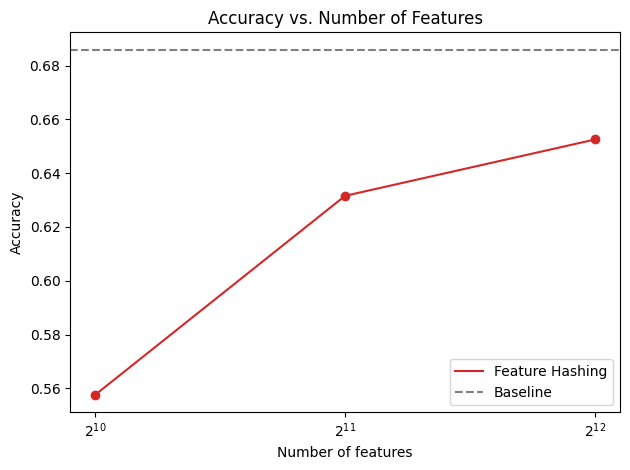

K         Accuracy  
1024      0.55756   
2048      0.63156   
4096      0.65252   


In [22]:
fig, ax1 = plt.subplots()

ax1.set_title('Accuracy vs. Number of Features')
ax1.set_xlabel('Number of features')
ax1.set_ylabel('Accuracy')
ax1.plot(K_VALS, fh_scores, color='tab:red', label='Feature Hashing')
ax1.scatter(K_VALS, fh_scores, color='tab:red')
ax1.axhline(y=baseline_score, color='gray', linestyle='--', label='Baseline')
ax1.set_xscale('log', base=2)
ax1.legend()

plt.tight_layout()
plt.show()

print(f"{'K':<10}{'Accuracy':<10}")
for i, k in enumerate(K_VALS):
    print(f"{k:<10}{fh_scores[i]:<10.5f}")

### Multi Feature Hashing

In [24]:
class MultiFeatureHashingGD():
    def __init__(self, n_features, feature_names, n_hashes=2, lr=0.01, epochs=10, batch_size=256):
        self.n_features = n_features
        self.feature_names = list(feature_names)
        self.feature_to_idx = {f: i for i, f in enumerate(feature_names)}
        self.n_hashes = n_hashes
        self.signs = self._hash_signs()
        self.hashes = [self._hash_features(seed=i) for i in range(n_hashes)]
        self.lr = lr
        self.epochs = epochs
        self.batch_size = batch_size
        self.V = None

    def _hash_signs(self):
        """Randomly assign signs to features for hashing."""
        return np.array(np.random.choice([-1, 1], size=len(self.feature_names)), dtype=np.int64)
    
    def _hash_features(self, seed):
        """Hash each feature name into a corresponding integer."""
        return np.array([mmh3.hash(f.encode('utf-8'), seed, signed=False) for f in self.feature_names], dtype=np.int64)
    
    def transform(self, X):
        """Transform input features into a hashed feature space."""
        X_hashed = np.zeros((len(X), self.n_features))
        
        for i in range(len(X)):
            for feature, value in X[i]:
                if feature not in self.feature_to_idx:
                    continue
                idx = self.feature_to_idx[feature]
                hs = [h[idx] % self.n_features for h in self.hashes]
                s = self.signs[idx]
                for h in hs:
                    X_hashed[i, h] += s * value / self.n_hashes**0.5
        
        return X_hashed
    
    def softmax(self, logits):
        """Compute the softmax of logits."""
        exp_logits = np.exp(logits - np.max(logits, axis=1, keepdims=True))
        return exp_logits / np.sum(exp_logits, axis=1, keepdims=True)
    
    def compute_grad_and_loss(self, X_batch, y_batch):
        """Compute the gradient and loss for a batch."""
        logits = X_batch @ self.V
        probs = self.softmax(logits)
        
        grad = X_batch.T @ (probs - y_batch) / len(y_batch) 
        loss = -np.mean(np.sum(y_batch * np.log(probs + 1e-8), axis=1))
        
        return grad, loss
    
    def fit(self, X, y):
        """Train the model using hashed weights and gradient descent."""
        n_classes = len(np.unique(y))
        self.V = np.random.randn(self.n_features, n_classes) * 0.001
        y_one_hot = np.eye(n_classes)[y]
        
        for epoch in range(self.epochs):
            epoch_loss = 0
            indices = np.arange(len(X))
            np.random.shuffle(indices)
            X, y_one_hot = [X[i] for i in indices], y_one_hot[indices]
            
            for i in range(0, len(X), self.batch_size):
                X_batch = X[i:i+self.batch_size]
                y_batch = y_one_hot[i:i+self.batch_size]
                
                X_batch_hashed = self.transform(X_batch)
                
                grad, batch_loss = self.compute_grad_and_loss(X_batch_hashed, y_batch)
                
                self.V -= self.lr * grad
                epoch_loss += batch_loss
            
            print(f"Epoch {epoch+1}/{self.epochs} - Loss: {epoch_loss:.5f}")
            
    def predict(self, X):
        """Make predictions using the trained model."""
        X_hashed = self.transform(X)
        logits = X_hashed @ self.V
        probs = self.softmax(logits)
        return np.argmax(probs, axis=1)

In [ ]:
mfh_scores = []

for n_hashes in C_VALS:
    print(f'Hashing with {n_hashes} hashes')
    scores = []
    for n_features in K_VALS:
        print(f"Training with {n_features} features")
        mfh = MultiFeatureHashingGD(n_features, feature_names, n_hashes)
        mfh.fit(X_train, y_train)
        y_pred = mfh.predict(X_test)
        score = accuracy_score(y_test, y_pred)
        scores.append(score)
        print(f"Accuracy: {score:.4f}")
    mfh_scores.append(scores)

Hashing with 2 hashes
Training with 1024 features
Epoch 1/10 - Loss: 176.73579
Epoch 2/10 - Loss: 176.70614
Epoch 3/10 - Loss: 176.67647
Epoch 4/10 - Loss: 176.64682
Epoch 5/10 - Loss: 176.61720
Epoch 6/10 - Loss: 176.58751
Epoch 7/10 - Loss: 176.55791
Epoch 8/10 - Loss: 176.52822
Epoch 9/10 - Loss: 176.49866
Epoch 10/10 - Loss: 176.46903
Accuracy: 0.5759
Training with 2048 features
Epoch 1/10 - Loss: 176.73405
Epoch 2/10 - Loss: 176.70478
Epoch 3/10 - Loss: 176.67553


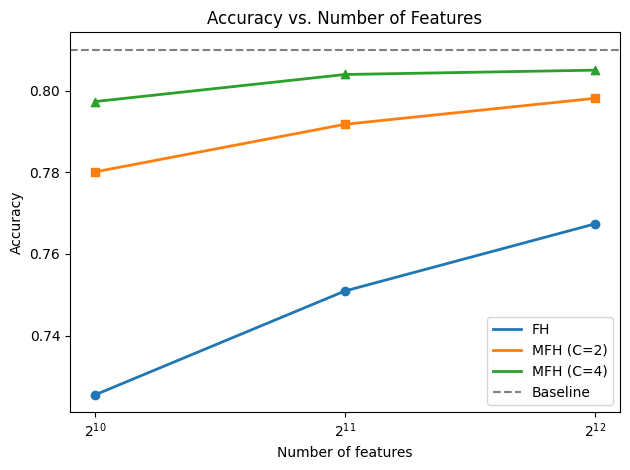

Accuracies:
K\C	FH	MFH2	MFH4
1024	0.72546	0.78011	0.79735
2048	0.75093	0.79178	0.80398
4096	0.76737	0.79814	0.80504

In [58]:
import matplotlib.pyplot as plt

colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown']
markers = ['o', 's', '^', 'D', 'x', '*']

fig, ax1 = plt.subplots()

ax1.set_title('Accuracy vs. Number of Features')
ax1.set_xlabel('Number of features')
ax1.set_ylabel('Accuracy')
ax1.plot(K_VALS, fh_scores, color=colors[0], label='FH', linestyle='-', linewidth=2)
ax1.scatter(K_VALS, fh_scores, color=colors[0], marker=markers[0])
for i, scores in enumerate(mfh_scores):
    ax1.plot(K_VALS, scores, color=colors[(i+1) % len(colors)], label=f'MFH (C={C_VALS[i]})', linestyle='-', linewidth=2)
    ax1.scatter(K_VALS, scores, color=colors[(i+1) % len(colors)], marker=markers[(i+1) % len(markers)])
ax1.axhline(y=baseline_score, color='gray', linestyle='--', label='Baseline')
ax1.set_xscale('log', base=2)
ax1.legend()

plt.tight_layout()
plt.show()

print('Accuracies:')
print('K\\C\tFH', end='')
for C in C_VALS:
    print(f'\tMFH{C}', end='')
    
for i, K in enumerate(K_VALS):
    print(f'\n{K}', end='')
    print(f'\t{fh_scores[i]:.5f}', end='')
    for j, C in enumerate(C_VALS):
        print(f'\t{mfh_scores[j][i]:.5f}', end='')

### Cuckoo Hashing

In [114]:
import numpy as np
import mmh3
from sklearn.neighbors import KNeighborsClassifier
from sklearn.calibration import LabelEncoder
from sklearn.utils import shuffle

class CuckooFeatureHasherNetwork:
    """
    Cuckoo Feature Hashing (CCFH) transformer and classifier.
    
    This class implements CCFH which addresses collisions in feature hashing
    by using a probabilistic mixture of two hash functions.
    
    Parameters:
    -----------
    feature_names : list
        List of all possible feature names.
    n_features : int
        Dimension of the projected feature space.
    q_ratio : float, default=0.2
        Ratio to determine dimension of q parameter.
    seed : int, default=0
        Random seed for reproducibility.
    clf : object, default=KNeighborsClassifier()
        Classifier to use for prediction.
    learning_rate : float, default=0.01
        Learning rate for gradient descent.
    epochs : int, default=10
        Number of training epochs.
    batch_size : int, default=256
        Batch size for training.
    l1 : float, default=0.1
        L1 regularization parameter.
    l2 : float, default=0.1
        L2 regularization parameter.
    momentum : float, default=0.9
        Momentum parameter for gradient descent.
    """
    def __init__(self, feature_names, n_features, clf=KNeighborsClassifier(), q_ratio=0.2, seed=0,
                 learning_rate=0.001, epochs=10, batch_size=256, l1=0.1, l2=0.1, momentum=0.9):
        self.feature_names = list(feature_names)
        self.feature_to_idx = {f: i for i, f in enumerate(feature_names)}
        self.n_features = n_features
        
        self.seed = seed
        self.signs = self._hash_signs(seed)
        self.hashes_1 = self._hash_features(seed)
        self.hashes_2 = self._hash_features(seed + 1)
        self.hashes_H = self._hash_features(seed + 2)
        
        self.q_ratio = q_ratio
        self.dim_q = max(1, int(self.q_ratio * self.n_features))
        self.q = np.full(self.dim_q, 0.5)
        
        self.clf = clf
        self._is_fitted = False
        
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.batch_size = batch_size
        self.l1 = l1
        self.l2 = l2
        self.momentum = momentum
        
        self.velocity = np.zeros_like(self.q)
        
        self.label_encoder = LabelEncoder()

    def _hash_signs(self, seed):
        """Generate random signs (+1/-1) for features."""
        np.random.seed(seed)
        return np.array(np.random.choice([-1, 1], size=len(self.feature_names)), dtype=np.int64)
    
    def _hash_features(self, seed):
        """Hash feature names to integers."""
        return np.array([mmh3.hash(f.encode('utf-8'), seed, signed=False) 
                        for f in self.feature_names], dtype=np.int64)
    
    def _get_bucket_indices(self, feature_idx):
        """Get the bucket indices for a feature index."""
        h1 = self.hashes_1[feature_idx] % self.n_features
        h2 = self.hashes_2[feature_idx] % self.n_features
        H_idx = self.hashes_H[feature_idx] % self.dim_q
        s = self.signs[feature_idx]
        return h1, h2, H_idx, s
    
    def transform(self, X):
        """
        Transform samples using Cuckoo Feature Hashing.
        
        Parameters:
        -----------
        X : list of lists
            Each inner list contains tuples of (feature_name, value)
            
        Returns:
        --------
        transformed : numpy.ndarray
            Transformed feature vectors
        """
        n_samples = len(X)
        transformed = np.zeros((n_samples, self.n_features))
        
        for i, sample in enumerate(X):
            for feature, value in sample:
                if value == 0 or feature not in self.feature_to_idx:
                    continue
                idx = self.feature_to_idx[feature]
                h1, h2, H_idx, s = self._get_bucket_indices(idx)
                transformed[i, h1] += value * self.q[H_idx] * s
                transformed[i, h2] += value * (1 - self.q[H_idx]) * s
                
        return transformed
    
    def compute_loss_and_gradient(self, X, y):
        # CCFH transformation
        X_transformed = self.transform(X)
        y_encoded = self.label_encoder.transform(y)
        
        # Classifier training
        self.clf.fit(X_transformed, y_encoded)
        y_pred_proba = self.clf.predict_proba(X_transformed)
        
        # Loss computation
        loss = -np.sum(np.log(y_pred_proba[np.arange(len(y_encoded)), y_encoded])) / len(y_encoded)
        l1_penalty = self.l1 * np.sum(np.abs(self.q))
        l2_penalty = self.l2 * np.sum(self.q ** 2)
        loss += l1_penalty + l2_penalty
        
        # Gradient computation
        grad_q = np.zeros_like(self.q)
        for i, sample in enumerate(X):
            for feature, value in sample:
                if value == 0 or feature not in self.feature_to_idx:
                    continue
                idx = self.feature_to_idx[feature]
                h1, h2, H_idx, s = self._get_bucket_indices(idx)
                grad_q[H_idx] += value * s * (X_transformed[i, h1] - X_transformed[i, h2])
        grad_q += self.l1 * np.sign(self.q) + 2 * self.l2 * self.q
        grad_q /= len(y_encoded)
        
        return loss, grad_q
    
    def train(self, X, y):
        y = self.label_encoder.fit_transform(y)
        for epoch in range(self.epochs):
            X, y = shuffle(X, y, random_state=self.seed)
            
            for i in range(0, len(X), self.batch_size):
                X_batch = X[i:i + self.batch_size]
                y_batch = y[i:i + self.batch_size]
                
                loss, grad_q = self.compute_loss_and_gradient(X_batch, y_batch)
                
                self.velocity = self.momentum * self.velocity + self.learning_rate * grad_q
                self.q -= self.velocity
                self.q -= self.learning_rate * grad_q
                self.q = np.clip(self.q, 0, 1)
                
            print(f"Epoch {epoch + 1}/{self.epochs}, Loss: {loss:.5f}")
        
        X_transformed = self.transform(X)
        self.clf.fit(X_transformed, y_train)

        self._is_fitted = True
    
    def predict(self, X):
        if not self._is_fitted:
            raise ValueError("Model is not trained. Call train() first.")
        X_transformed = self.transform(X)
        return self.clf.predict(X_transformed)

In [115]:
X_train, X_test, y_train, y_test = train_test_split(X_dense_bow, y, test_size=0.2, random_state=42)

cckh_scores = []

for n_features in K_VALS:
    print(f'Hashing with {n_features} features')
    cckh = CuckooFeatureHasherNetwork(feature_names, n_features)
    cckh.train(X_train, y_train)
    y_pred = cckh.predict(X_test)
    score = accuracy_score(y_test, y_pred)
    print(f'K={n_features}, Accuracy={score:.5f}')
    cckh_scores.append(score)

Hashing with 1024 features
Epoch 1/10, Loss: 16.51500
Epoch 2/10, Loss: 16.42686
Epoch 3/10, Loss: 16.35066
Epoch 4/10, Loss: 16.40120
Epoch 5/10, Loss: 16.37214
Epoch 6/10, Loss: 16.39759
Epoch 7/10, Loss: 16.37807
Epoch 8/10, Loss: 16.34366
Epoch 9/10, Loss: 16.26077
Epoch 10/10, Loss: 16.24114
K=1024, Accuracy=0.04483
Hashing with 2048 features
Epoch 1/10, Loss: 31.81191


KeyboardInterrupt: 

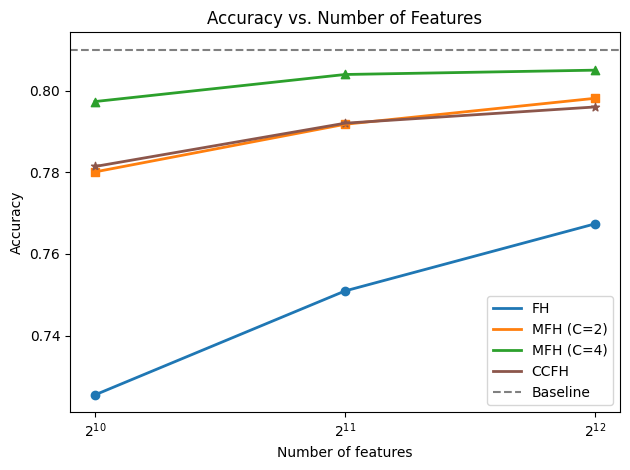

Accuracies:
K\C	FH	MFH2	MFH4	CCFH
1024	0.72546	0.78011	0.79735	0.78143
2048	0.75093	0.79178	0.80398	0.79204
4096	0.76737	0.79814	0.80504	0.79602


In [89]:
fig, ax1 = plt.subplots()

ax1.set_title('Accuracy vs. Number of Features')
ax1.set_xlabel('Number of features')
ax1.set_ylabel('Accuracy')
ax1.plot(K_VALS, fh_scores, color=colors[0], label='FH', linestyle='-', linewidth=2)
ax1.scatter(K_VALS, fh_scores, color=colors[0], marker=markers[0])
for i, scores in enumerate(mfh_scores):
    ax1.plot(K_VALS, scores, color=colors[(i+1) % len(colors)], label=f'MFH (C={C_VALS[i]})', linestyle='-', linewidth=2)
    ax1.scatter(K_VALS, scores, color=colors[(i+1) % len(colors)], marker=markers[(i+1) % len(markers)])
ax1.plot(K_VALS, cckh_scores, color=colors[-1], label='CCFH', linestyle='-', linewidth=2)
ax1.scatter(K_VALS, cckh_scores, color=colors[-1], marker=markers[-1])
ax1.axhline(y=baseline_score, color='gray', linestyle='--', label='Baseline')
ax1.set_xscale('log', base=2)
ax1.legend()

plt.tight_layout()
plt.show()

print('Accuracies:')
print('K\\C\tFH', end='')
for C in C_VALS:
    print(f'\tMFH{C}', end='')
print('\tCCFH')
for i, K in enumerate(K_VALS):
    print(f'{K}', end='')
    print(f'\t{fh_scores[i]:.5f}', end='')
    for j, C in enumerate(C_VALS):
        print(f'\t{mfh_scores[j][i]:.5f}', end='')
    print(f'\t{cckh_scores[i]:.5f}', end='')
    print()